In [2]:
from scipy.signal import find_peaks
from astropy.io import fits
from specutils import Spectrum1D
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import requests
from io import BytesIO
import os
import csv


## Define Functions to inject, detect, and analyze

In [3]:
def inject_and_plot_laser(obj_id, filt, folder="/datax/scratch/emmay/galah_spectra",
                          fwhm=1.5, laser_amp_percent=20, plot=True):
    """
    Injects a Gaussian laser spike into GALAH FITS spectrum and plots it.

    Parameters:
        obj_id (str): Object ID
        filt (str): Filter (e.g. 'B', 'V', 'R', 'I')
        folder (str): Path to FITS files
        fwhm (float): FWHM of the Gaussian in pixels
        laser_amp_percent (float): Amplitude of injection as percentage of max flux
        plot (bool): Whether to show the plot

    Returns:
        wavelength (np.ndarray): Wavelength array (in Å)
        flux_injected (np.ndarray): Flux array with injected Gaussian
    """
    filename = f"{obj_id}_{filt}.fits"
    path = os.path.join(folder, filename)

    with fits.open(path) as hdul:
        header = hdul[1].header
        flux = hdul[1].data.astype(float)

    # Build wavelength axis
    crval1 = header.get('CRVAL1')
    cdelt1 = header.get('CDELT1')
    crpix1 = header.get('CRPIX1', 1)

    npix = len(flux)
    wavelength = (crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1) * u.AA

    # Inject Gaussian
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    center = np.random.randint(0, npix)  # random pixel index in [0, npix-1]
    x = np.arange(npix)
    gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
    gaussian *= (laser_amp_percent / 100.0) * np.nanmax(flux)

    flux_injected = flux + gaussian

    # Plot
    if plot:
        threshold_mask = gaussian > 1e-4
        plt.figure(figsize=(13, 5))
        plt.plot(wavelength, flux, color='blue', linewidth=0.6, label="Original Spectrum")
        plt.plot(wavelength[threshold_mask], flux_injected[threshold_mask], color='red', linewidth=1.0, label="Injected Region")
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title(f"Injected Spectrum — {obj_id} ({filt}) — Amplitude = {laser_amp_percent}%")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return wavelength.value, flux_injected, flux, wavelength[center], laser_amp_percent


In [22]:
def measure_width_at_y(flux, wavelength, peak_idx, y_level=1):
    """Measure width of a peak at a fixed y_level using linear interpolation."""
    # Left side
    i = peak_idx
    while i > 0 and flux[i] > y_level:
        i -= 1
    if i == 0 or flux[i] > y_level:
        return None  # No valid left edge
    left = wavelength[i] + (y_level - flux[i]) / (flux[i+1] - flux[i]) * (wavelength[i+1] - wavelength[i])

    # Right side
    i = peak_idx
    while i < len(flux) - 1 and flux[i] > y_level:
        i += 1
    if i == len(flux) - 1 or flux[i] > y_level:
        return None  # No valid right edge
    right = wavelength[i-1] + (y_level - flux[i-1]) / (flux[i] - flux[i-1]) * (wavelength[i] - wavelength[i-1])

    return left, right, right - left

def detect_laser_peak_with_fixed_level_width(
    wavelength, 
    flux, 
    height_fraction=0.2, 
    y_level=1.0, 
    max_pixel_width=3,
    injected_wavelength=None,
    plot=True
):
    """
    Detect laser-like peaks and measure width above a fixed y-level.

    Parameters
    ----------
    wavelength : array
        Wavelength array.
    flux : array
        Flux array.
    height_fraction : float
        Threshold for peak prominence (fraction of max flux).
    y_level : float
        Fixed flux level at which to measure peak width.
    max_pixel_width : float
        Maximum allowed width in pixel units for valid peaks.
    plot : bool
        If True, show zoomed-in and full-spectrum plots.

    Returns
    -------
    peak_wavelengths : list of float
        Wavelengths of detected peaks.
    widths : list of float
        Widths measured at y_level.
    """

    # Remove units if present
    flux = np.asarray(flux)
    wavelength = np.asarray(wavelength)
        
    height_threshold = height_fraction * max(np.abs(flux - 1))
    peak_indices, properties = find_peaks(flux, height=height_threshold*np.nanmax(flux)+1)

    # Handle case where no peaks are found
    if len(peak_indices) == 0:
        #print("No peaks detected.")
        if plot:
            plt.figure(figsize=(12, 4))
            plt.plot(wavelength, flux, label="Full Spectrum")
            if injected_wavelength is not None:
                plt.axvline(x=float(injected_wavelength.value), color='r', linestyle='--', linewidth=2, label="Injected Laser")
            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux")
            plt.title("Full Spectrum (No Peaks Detected)")
            plt.legend()
            plt.tight_layout()
            plt.show()
        return [], []

    peak_wavelengths = []
    widths = []
    valid_peak_indices = []

    # Estimate pixel scale (assuming evenly spaced wavelength)
    pixel_scale = np.median(np.diff(wavelength))

    for i, idx in enumerate(peak_indices):
        result = measure_width_at_y(flux, wavelength, idx, y_level=y_level)
        if result is not None:
            left, right, width = result
            #print(type(left),type(right),type(width))
            width_in_pixels = width / pixel_scale

            if width_in_pixels > max_pixel_width:
                continue  # Skip wide peaks

            peak_wavelengths.append(wavelength[idx])
            widths.append(width)
            valid_peak_indices.append(idx)

            if plot:
                i_min = max(0, idx - 20)
                i_max = min(len(wavelength), idx + 20)

                plt.figure(figsize=(10, 4))
                plt.plot(wavelength[i_min:i_max], flux[i_min:i_max], label="Flux")
                plt.axvline(left, color='C2', linestyle='--')
                plt.axvline(right, color='C2', linestyle='--')
                plt.hlines(y_level, left, right, color='C3', linewidth=2, label=f'Width @ y={y_level}')
                plt.plot(wavelength[idx], flux[idx], 'rx', label="Peak Center")
                plt.xlabel("Wavelength (Å)")
                plt.ylabel("Flux")
                plt.title(f"Zoomed Peak at {wavelength[idx]:.2f} Å, Width = {width:.3f} Å ({width_in_pixels:.2f} px)")
                plt.legend()
                plt.tight_layout()
                plt.show()
                
    # Plot full spectrum with vertical lines
    if plot and valid_peak_indices:
        plt.figure(figsize=(12, 4))
        plt.plot(wavelength, flux, label="Full Spectrum")
        first = True
        for idx in valid_peak_indices:
            #plt.axvline(wavelength[idx], color='blue', linestyle='--', alpha=0.7)
            if first:
                plt.plot(wavelength[idx], flux[idx], 'rx', label="Detected Peaks")
                first=False
            else:
                plt.plot(wavelength[idx], flux[idx], 'rx')



        if injected_wavelength is not None:
            plt.axvline(x=float(injected_wavelength.value), color='black', linestyle='--', linewidth=2, label="Injected Laser")

        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title("Full Spectrum with Detected Peaks")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return peak_wavelengths, widths


In [5]:
def evaluate_detection(injected_wavelengths, detected_wavelengths, threshold_angstroms=2.0):
    """
    Compare injected laser wavelengths to detected peaks and compute performance metrics.

    Parameters:
    - injected_wavelengths: list of float or Quantity
    - detected_wavelengths: list of float or Quantity
    - threshold_angstroms: float, matching window in angstroms

    Returns:
    - stats: dict with TP, FP, FN, precision, recall, F1, n_injected, n_detected
    - matched_flags: list of bool per injected wavelength
    """
    def to_angstroms(wl):
        return float(wl.to_value('angstrom')) if hasattr(wl, 'to_value') else float(wl)

    injected_wavelengths = [to_angstroms(wl) for wl in injected_wavelengths]
    detected_wavelengths = [to_angstroms(wl) for wl in detected_wavelengths]

    matched_injected = [False] * len(injected_wavelengths)
    matched_detected = [False] * len(detected_wavelengths)

    for i, inj_wl in enumerate(injected_wavelengths):
        for j, det_wl in enumerate(detected_wavelengths):
            if not matched_detected[j] and abs(det_wl - inj_wl) <= threshold_angstroms:
                matched_injected[i] = True
                matched_detected[j] = True
                break

    TP = sum(matched_injected)
    FN = len(injected_wavelengths) - TP
    FP = len(detected_wavelengths) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    stats = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "n_injected": len(injected_wavelengths),
        "n_detected": len(detected_wavelengths)
    }

    return stats, matched_injected


## Check for invalid files

In [ ]:
# Folder and file list
folder = "/datax/scratch/emmay/galah_spectra"
fits_files = [f for f in os.listdir(folder) if f.endswith(".fits")]

invalid_files = []

# Check validity of each FITS file
for fname in fits_files:
    file_path = os.path.join(folder, fname)
    try:
        with fits.open(file_path, ignore_missing_simple=False) as hdul:
            pass  # Successfully opened
    except Exception as e:
        print(f"Invalid FITS file: {fname} ({e})")
        invalid_files.append(fname)

# Print summary
print(f"\nTotal FITS files checked: {len(fits_files)}")
print(f"Number of invalid FITS files: {len(invalid_files)}")


Invalid FITS file: 170829001901361_I.fits (No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True)
Invalid FITS file: 171003003601198_I.fits (No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True)
Invalid FITS file: 171003003601255_I.fits (No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True)
Invalid FITS file: 171003003601083_I.fits (No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True)
Invalid FITS file: 171003003601369_I.fits (No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True)
Invalid FITS file: 171003003601008_I.fits (No SIMPLE card found, this file does 

NameError: name 'Table' is not defined

In [9]:
import os
from astropy.io import fits
from astropy.table import Table

# Save to table
if invalid_files:
    table = Table([invalid_files], names=["invalid_filenames"])
    table.write("invalid_fits_files.csv", format="csv", overwrite=True)
    print("Saved list of invalid files to 'invalid_fits_files.csv'")

Saved list of invalid files to 'invalid_fits_files.csv'


In [12]:
import pandas as pd
invalid_df = pd.read_csv('invalid_fits_files.csv')
# Extract the character before '.fits' (i.e., the filter letter)
invalid_df['filter'] = invalid_df['invalid_filenames'].str.extract(r'_([B|V|R|I])\.fits$')

# Count the occurrences of each filter
filter_counts = invalid_df['filter'].value_counts()

# Display counts for B, V, R, I (in that order)
for band in ['B', 'V', 'R', 'I']:
    count = filter_counts.get(band, 0)
    print(f"{band}: {count}")

B: 9
V: 9
R: 10
I: 168


## Inject 1 laser per spectrum

In [24]:
import os
import numpy as np

# Loop through all files in the folder
folder = "/datax/scratch/emmay/galah_spectra"
fits_files = [f for f in os.listdir(folder) if f.endswith(".fits")]

# Parameters
threshold_angstroms = 2.0
height_fraction = 0.15
y_level = 1.0
max_pixel_width = 5

# To store results
injected_wavelengths_all = []
injected_amplitudes_all = []
recovered_flags_all = []
# Add this list to store number of false positives per injection
false_positives_all = []

for fits_file in fits_files[:20]:  # Adjust number as needed
    filename_no_ext = fits_file[:-5]
    obj_id = filename_no_ext[:15]
    filt = filename_no_ext[16:]

    try:
        # Inject laser; assume this returns amplitude as 'injected_amplitude' or similar

        wave, flux, flux_orig, injected_wl, injected_amplitude = inject_and_plot_laser(
            obj_id, filt, folder=folder, laser_amp_percent=np.random.uniform(0, 100), plot=False
        )

        # Detect peaks; unpack only detected wavelengths
        detected_wavelengths, _ = detect_laser_peak_with_fixed_level_width(
            wave, flux,
            height_fraction=height_fraction,
            y_level=y_level,
            max_pixel_width=max_pixel_width,
            injected_wavelength=injected_wl,
            plot=False
        )

        # Evaluate detection
        stats, matched = evaluate_detection(
            injected_wavelengths=[injected_wl],
            detected_wavelengths=detected_wavelengths,
            threshold_angstroms=threshold_angstroms
        )

        # Count how many detected peaks did *not* match the injected wavelength
        n_false_positives = len(detected_wavelengths) - int(matched[0])
        false_positives_all.append(n_false_positives)

        # Save data for plotting later
        injected_wavelengths_all.append(injected_wl)
        injected_amplitudes_all.append(injected_amplitude)
        recovered_flags_all.append(matched[0])  # matched is list of bool, one per injection

    except Exception as e:
        # Skip file if error occurs
        print('skipped file')
        print(f"Error processing {fits_file}: {e}")
        continue

# Convert to numpy arrays for easier analysis
injected_wavelengths_all = np.array([w.to_value(u.Angstrom) for w in injected_wavelengths_all])
injected_amplitudes_all = np.array(injected_amplitudes_all)
recovered_flags_all = np.array(recovered_flags_all)

# Now you can make:

# 1. Completeness curve: For binned amplitude values, compute fraction recovered
amplitude_bins = np.linspace(injected_amplitudes_all.min(), injected_amplitudes_all.max(), 10)
completeness = []

for i in range(len(amplitude_bins)-1):
    bin_mask = (injected_amplitudes_all >= amplitude_bins[i]) & (injected_amplitudes_all < amplitude_bins[i+1])
    if np.any(bin_mask):
        fraction_recovered = np.mean(recovered_flags_all[bin_mask])
    else:
        fraction_recovered = np.nan
    completeness.append(fraction_recovered)

completeness = np.array(completeness)
# amplitude_bins[:-1] gives bin starts for plotting

# 2. Injection scatter: wavelength vs amplitude, color by recovered_flags_all
# Store these arrays and plot later as needed


In [6]:
np.savez(
    "single_laser_injection_results.npz",
    injected_wavelengths=injected_wavelengths_all,
    injected_amplitudes=injected_amplitudes_all,
    recovered_flags=recovered_flags_all
)


## Run the detection without injections

In [26]:
false_positives_per_spectrum = {}

for fits_file in fits_files[:40]:
    try:
        filename_no_ext = fits_file[:-5]
        obj_id = filename_no_ext[:15]
        filt = filename_no_ext[16:]
        spectrum_id = f"{obj_id}_{filt}"

        # Load spectrum (no injection)
        wave, flux, flux_orig, injected_wl, injected_amplitude = inject_and_plot_laser(
                    obj_id, filt, folder=folder, laser_amp_percent=np.random.uniform(0, 100), plot=False
                )
        # Detect peaks without injection
        detected_wavelengths, _ = detect_laser_peak_with_fixed_level_width(
            wave, flux,
            height_fraction=height_fraction,
            y_level=y_level,
            max_pixel_width=max_pixel_width,
            injected_wavelength=None,
            plot=False
        )

        # Count how many peaks it finds — these are your "false positives" in the no-injection case
        false_positives_per_spectrum[spectrum_id] = len(detected_wavelengths)

    except Exception as e:
        print(f"Skipped {fits_file}: {e}")
        continue


In [27]:
df_fp = pd.DataFrame({
    "spectrum": list(false_positives_per_spectrum.keys()),
    "num_false_positives": list(false_positives_per_spectrum.values())
})

# Basic stats
print(f"Mean false positives per spectrum: {df_fp['num_false_positives'].mean():.2f}")
print(f"Median false positives per spectrum: {df_fp['num_false_positives'].median():.2f}")
print(df_fp.sort_values("num_false_positives", ascending=False).head())

Mean false positives per spectrum: 2.05
Median false positives per spectrum: 1.00
             spectrum  num_false_positives
25  161118002501129_V                   17
37  170910004101382_V                   11
19  201002002601346_I                    5
11  161118002501241_I                    4
35  140708007101168_I                    4


## Now Inject 1000 lasers per spectrum

In [ ]:
import os
import numpy as np

# Loop through all files in the folder
folder = "/datax/scratch/emmay/galah_spectra"
fits_files = [f for f in os.listdir(folder) if f.endswith(".fits")]

# Parameters
threshold_angstroms = 2.0
height_fraction = 0.15
y_level = 1.0
max_pixel_width = 5

# To store results
injected_wavelengths_all = []
injected_amplitudes_all = []
recovered_flags_all = []
# Add this list to store number of false positives per injection
false_positives_all = []

for fits_file in fits_files[:40]:  # Adjust number as needed
    filename_no_ext = fits_file[:-5]
    obj_id = filename_no_ext[:15]
    filt = filename_no_ext[16:]

    for i in range(1000):

        try:
            # Inject laser; assume this returns amplitude as 'injected_amplitude' or similar

            wave, flux, flux_orig, injected_wl, injected_amplitude = inject_and_plot_laser(
                obj_id, filt, folder=folder, laser_amp_percent=np.random.uniform(0, 100), plot=False
            )

            # Detect peaks; unpack only detected wavelengths
            detected_wavelengths, _ = detect_laser_peak_with_fixed_level_width(
                wave, flux,
                height_fraction=height_fraction,
                y_level=y_level,
                max_pixel_width=max_pixel_width,
                injected_wavelength=injected_wl,
                plot=False
            )

            # Evaluate detection
            stats, matched = evaluate_detection(
                injected_wavelengths=[injected_wl],
                detected_wavelengths=detected_wavelengths,
                threshold_angstroms=threshold_angstroms
            )

            # Count how many detected peaks did *not* match the injected wavelength
            n_false_positives = len(detected_wavelengths) - 1
            false_positives_all.append(n_false_positives)

            # Save data for plotting later
            injected_wavelengths_all.append(injected_wl)
            injected_amplitudes_all.append(injected_amplitude)
            recovered_flags_all.append(matched[0])  # matched is list of bool, one per injection

        except Exception as e:
            # Skip file if error occurs
            print('skippied file')
            print(f"Error processing {fits_file}: {e}")
            continue

# Convert to numpy arrays for easier analysis
injected_wavelengths_all = np.array([w.to_value(u.Angstrom) for w in injected_wavelengths_all])
injected_amplitudes_all = np.array(injected_amplitudes_all)
recovered_flags_all = np.array(recovered_flags_all)

# Now you can make:

# 1. Completeness curve: For binned amplitude values, compute fraction recovered
amplitude_bins = np.linspace(injected_amplitudes_all.min(), injected_amplitudes_all.max(), 10)
completeness = []

for i in range(len(amplitude_bins)-1):
    bin_mask = (injected_amplitudes_all >= amplitude_bins[i]) & (injected_amplitudes_all < amplitude_bins[i+1])
    if np.any(bin_mask):
        fraction_recovered = np.mean(recovered_flags_all[bin_mask])
    else:
        fraction_recovered = np.nan
    completeness.append(fraction_recovered)

completeness = np.array(completeness)
# amplitude_bins[:-1] gives bin starts for plotting

# 2. Injection scatter: wavelength vs amplitude, color by recovered_flags_all
# Store these arrays and plot later as needed


In [14]:
np.savez(
    "thousand_laser_injection_results.npz",
    injected_wavelengths=injected_wavelengths_all,
    injected_amplitudes=injected_amplitudes_all,
    recovered_flags=recovered_flags_all,
    false_positives=false_positives_all
)


In [15]:
# Load the .npz file
data = np.load("thousand_laser_injection_results.npz")

# Access the arrays
injected_wavelengths_all = data["injected_wavelengths"]
injected_amplitudes_all = data["injected_amplitudes"]
recovered_flags_all = data["recovered_flags"]
false_positives_all = data["false_positives"]

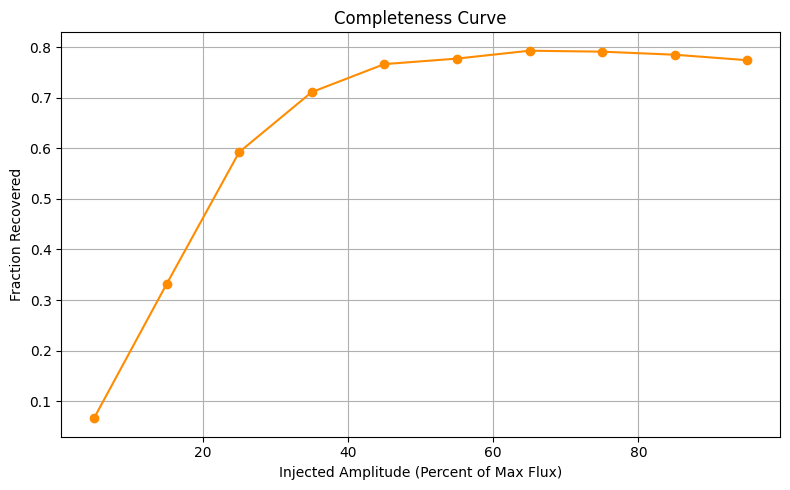

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define bins for amplitude
n_bins = 10
amplitude_bins = np.linspace(injected_amplitudes_all.min(), injected_amplitudes_all.max(), n_bins + 1)

# Compute fraction recovered per bin
bin_centers = 0.5 * (amplitude_bins[:-1] + amplitude_bins[1:])
completeness = []

for i in range(n_bins):
    in_bin = (injected_amplitudes_all >= amplitude_bins[i]) & (injected_amplitudes_all < amplitude_bins[i+1])
    if np.any(in_bin):
        frac = np.mean(recovered_flags_all[in_bin])
    else:
        frac = np.nan
    completeness.append(frac)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, completeness, marker='o', linestyle='-', color='darkorange')
plt.xlabel("Injected Amplitude (Percent of Max Flux)")
plt.ylabel("Fraction Recovered")
plt.title("Completeness Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


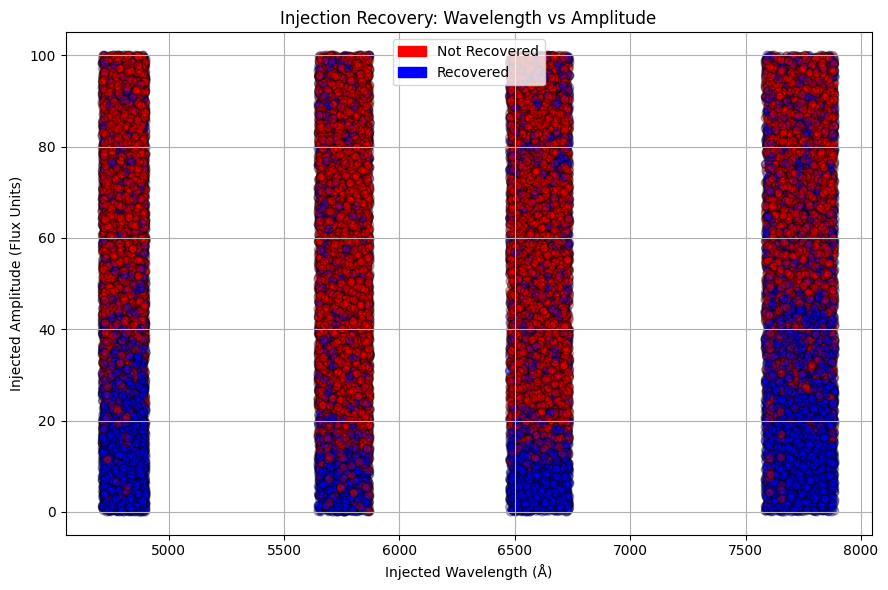

In [10]:
# Create scatter plot: wavelength vs amplitude, colored by recovery status
colors = np.where(recovered_flags_all, "green", "red")
labels = np.where(recovered_flags_all, "Recovered", "Missed")

plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    injected_wavelengths_all,
    injected_amplitudes_all,
    c=recovered_flags_all,
    cmap="bwr",
    edgecolor="k",
    alpha=0.3,
)

plt.xlabel("Injected Wavelength (Å)")
plt.ylabel("Injected Amplitude (Flux Units)")
plt.title("Injection Recovery: Wavelength vs Amplitude")
plt.grid(True)
plt.tight_layout()

# Custom legend
from matplotlib.patches import Patch
plt.legend(handles=[
    Patch(color="red", label="Not Recovered"),
    Patch(color="blue", label="Recovered")
])
plt.show()


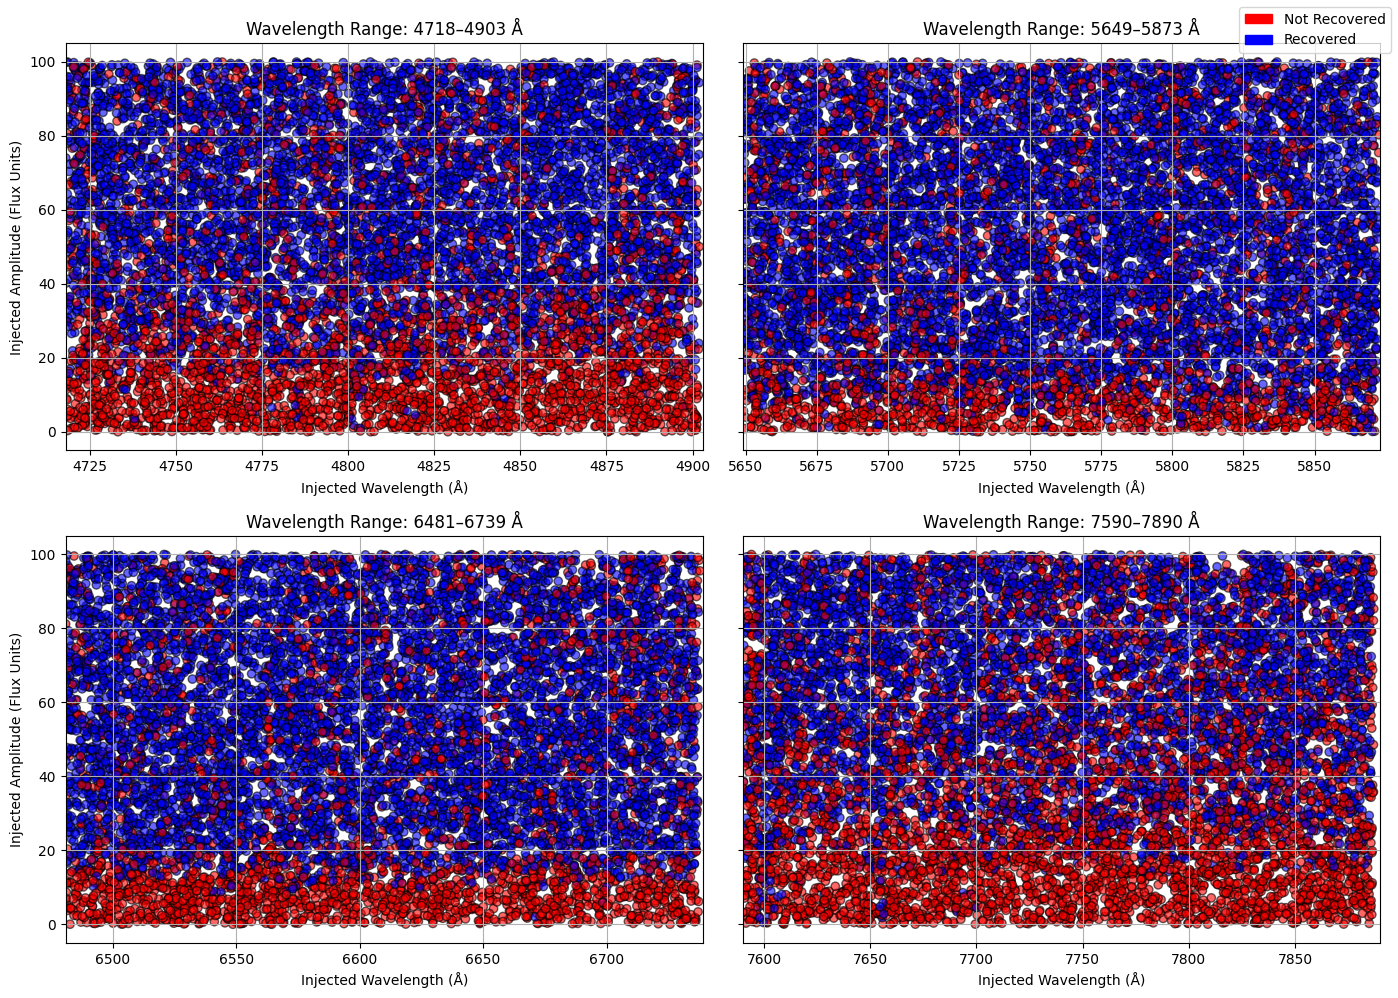

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Assuming these arrays exist:
# injected_wavelengths_all, injected_amplitudes_all, recovered_flags_all

# Your 4 wavelength ranges
wavelength_ranges = [
    (4718, 4903),
    (5649, 5873),
    (6481, 6739),
    (7590, 7890)
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axs = axs.flatten()

for i, (wmin, wmax) in enumerate(wavelength_ranges):
    ax = axs[i]
    # Mask for points in this wavelength range
    mask = (injected_wavelengths_all >= wmin) & (injected_wavelengths_all <= wmax)
    
    # Scatter plot with recovery colored: blue = recovered (True), red = missed (False)
    scatter = ax.scatter(
        injected_wavelengths_all[mask],
        injected_amplitudes_all[mask],
        c=recovered_flags_all[mask],
        cmap='bwr_r',
        edgecolor='k',
        alpha=0.6,
        vmin=0, vmax=1  # Ensure colors correspond to False=0 (red) and True=1 (blue)
    )
    
    ax.set_xlim(wmin, wmax)
    ax.set_xlabel("Injected Wavelength (Å)")
    if i % 2 == 0:
        ax.set_ylabel("Injected Amplitude (Flux Units)")
    ax.set_title(f"Wavelength Range: {wmin}–{wmax} Å")
    ax.grid(True)

# Custom legend (outside loop)
fig.legend(
    handles=[
        Patch(color='red', label='Not Recovered'),
        Patch(color='blue', label='Recovered')
    ],
    loc='upper right'
)

plt.tight_layout()
plt.show()


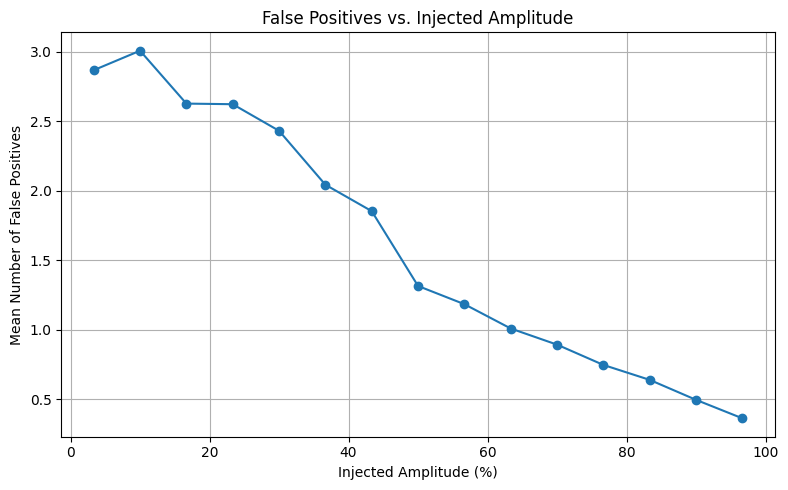

In [17]:
# Assume these are already loaded
# injected_amplitudes_all, false_positives_all

# Define bins for amplitudes
n_bins = 15
bins = np.linspace(injected_amplitudes_all.min(), injected_amplitudes_all.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
mean_false_positives = []

# Compute mean number of false positives per bin
for i in range(n_bins):
    bin_mask = (injected_amplitudes_all >= bins[i]) & (injected_amplitudes_all < bins[i+1])
    if np.any(bin_mask):
        mean_fp = np.mean(false_positives_all[bin_mask])
    else:
        mean_fp = np.nan
    mean_false_positives.append(mean_fp)

mean_false_positives = np.array(mean_false_positives)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, mean_false_positives, marker='o')
plt.xlabel("Injected Amplitude (%)")
plt.ylabel("Mean Number of False Positives")
plt.title("False Positives vs. Injected Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

# Total number of false positives
total_false_positives = np.sum(false_positives_all)
print(f"Total false positives: {total_false_positives}")

# Average false positives per spectrum
# You must know how many spectra (FITS files) you injected into.
# For example, if you did 1000 injections per spectrum and have 10 spectra:
num_injections_per_spectrum = 1000
average_fp_per_injection = total_false_positives / len(false_positives_all)

print(f"Average false positives per injection: {average_fp_per_injection:.2f}")


Total false positives: 64177
Average false positives per injection: 1.60
